In [1]:
import pandas as pd
import os
import joblib
from data_processing.main import read_scoreset
from tqdm import tqdm
from pathlib import Path
from data_processing.mapping_nbs import mapping_utils
from data_processing.mapping_nbs import plotting
pd.set_option('display.max_columns', 500)

dataset_name = "Kotler_TP53_RelativeFitnessH1299"
dataset_path = Path("/data/dzeiberg/mave_calibration/data/") / dataset_name
assert dataset_path.exists()

In [7]:
metadata, gene_info, gnomAD_df, spliceAI_df, clinvar_df = mapping_utils.load_mapping_data()

In [2]:
scoreset = read_scoreset(dataset_path / "scoreset.csv")

In [3]:
scoreset.Mut_type.value_counts()

Mut_type
Sub      2552
AASub    2231
Name: count, dtype: int64

In [18]:
scoreset_agg = scoreset.groupby(['hgvs_pro','Seq_change']).agg(dict(score='mean')).reset_index()


In [41]:
scoreset_agg = pd.merge(scoreset_agg.set_index('hgvs_pro'),scoreset.loc[:,['hgvs_pro','synonymous','nonsense']].drop_duplicates().set_index('hgvs_pro'),left_index=True,right_index=True)

In [42]:
if "author_transcript" not in scoreset.columns or scoreset.author_transcript.isna().all():
    AUTHOR_TRANSCRIPT = gene_info.loc[metadata.loc[dataset_name],'MANE_RefSeq_nuc'].values[0].split(".")[0]
else:
    AUTHOR_TRANSCRIPT = scoreset.author_transcript.iloc[0].split(".")[0]

In [43]:
AUTHOR_TRANSCRIPT

'NM_000546'

# Add ClinVar annotations

In [44]:
clinvar_hgvs_pro_summaries = mapping_utils.get_clinvar_summaries(clinvar_df,AUTHOR_TRANSCRIPT)

  0%|          | 0/1612 [00:00<?, ?it/s]

100%|██████████| 1612/1612 [00:00<00:00, 1913.73it/s]


In [45]:
clinvar_hgvs_pro_summaries

,num_p_lp,num_b_lb,num_conflicting,num_VUS,clinvar_names,clinvar_records,clinvar_spliceAI_max
hgvs_pro,,,,,,,
p.Ala119Asp,0,0,0,1,NM_000546.6(TP53):c.356C>A (p.Ala119Asp),1,0.01
p.Ala119Gly,0,0,1,0,NM_000546.6(TP53):c.356C>G (p.Ala119Gly),1,0.82
p.Ala119Pro,0,0,0,1,NM_000546.6(TP53):c.355G>C (p.Ala119Pro),1,0.01
p.Ala129=,0,1,0,0,NM_000546.6(TP53):c.387C>T (p.Ala129=),1,0.00
p.Ala129Asp,0,1,0,0,NM_000546.6(TP53):c.386C>A (p.Ala129Asp),1,0.00
...,...,...,...,...,...,...,...
p.Val97Ala,0,0,0,1,NM_000546.6(TP53):c.290T>C (p.Val97Ala),1,0.08
p.Val97Asp,0,0,0,1,NM_000546.6(TP53):c.290T>A (p.Val97Asp),1,0.09
p.Val97Ile,0,0,0,1,NM_000546.6(TP53):c.289G>A (p.Val97Ile),1,0.01


In [46]:
scoreset_agg

,Seq_change,score,synonymous,nonsense
hgvs_pro,,,,
p.Ala119Ala,C>A,-1.650135,True,False
p.Ala119Ala,C>G,-3.049731,True,False
p.Ala119Ala,C>T,-1.946923,True,False
p.Ala119Arg,GCC>CGC,-1.927312,False,False
p.Ala119Asn,GCC>AAC,-2.405210,False,False
...,...,...,...,...
p.Val274Thr,GTT>ACT,0.362743,False,False
p.Val274Tyr,GTT>TAT,0.016391,False,False
p.Val274Val,T>A,-2.079977,True,False


In [47]:
scoreset_w_clinvar = pd.merge(scoreset_agg,clinvar_hgvs_pro_summaries,
                            left_on='hgvs_pro',
                            right_index=True,
                            how="left",
                            validate="many_to_one",
                            suffixes=("","_clinvar"))

# Add gnomAD annotations

In [48]:
Ensembl_transcript_stable_ids = mapping_utils.translate_refseq_to_ensembl(AUTHOR_TRANSCRIPT)

In [49]:
Ensembl_transcript_stable_ids

array(['ENST00000269305'], dtype=object)

In [50]:
gnomAD_info = mapping_utils.gather_gnomAD_info(gnomAD_df,Ensembl_transcript_stable_ids,[AUTHOR_TRANSCRIPT,])

In [60]:
gnomAD_info

,gnomAD_variants_maxAC_AF,gnomAD_variants_max_spliceAI_score,gnomAD_variants_VCF_INFO
hgvs_pro,,,
p.Ala119Thr,6.849430e-07,0.00,17:7676014:C:T|17:7676014:C:T
p.Ala129Ser,1.368240e-06,0.01,17:7675227:C:A|17:7675227:C:A|17:7675227:C:A|1...
p.Ala129Thr,6.576180e-06,0.00,17:7675227:C:T|17:7675227:C:T|17:7675227:C:T|1...
p.Ala159Pro,1.368110e-06,0.00,17:7675137:C:G|17:7675137:C:G
p.Ala159Thr,1.368110e-06,0.00,17:7675137:C:T|17:7675137:C:T
...,...,...,...
p.Val31Ile,1.628310e-04,0.00,17:7676387:C:T|17:7676387:C:T|17:7676387:C:T|1...
p.Val73Met,2.600910e-05,0.07,17:7676152:C:T|17:7676152:C:T|17:7676152:C:T|1...
p.Val97Ile,1.369380e-06,0.01,17:7676080:C:T|17:7676080:C:T


In [52]:
scoreset_w_clinvar

,Seq_change,score,synonymous,nonsense,num_p_lp,num_b_lb,num_conflicting,num_VUS,clinvar_names,clinvar_records,clinvar_spliceAI_max
hgvs_pro,,,,,,,,,,,
p.Ala119Ala,C>A,-1.650135,True,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN
p.Ala119Ala,C>G,-3.049731,True,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN
p.Ala119Ala,C>T,-1.946923,True,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN
p.Ala119Arg,GCC>CGC,-1.927312,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN
p.Ala119Asn,GCC>AAC,-2.405210,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
p.Val274Thr,GTT>ACT,0.362743,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN
p.Val274Tyr,GTT>TAT,0.016391,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN
p.Val274Val,T>A,-2.079977,True,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [53]:
scoreset_processed = pd.merge(scoreset_w_clinvar,gnomAD_info,
                                        left_index=True,right_index=True,how="left",validate="many_to_one").reset_index()

In [54]:
scoreset_processed

,hgvs_pro,Seq_change,score,synonymous,nonsense,num_p_lp,num_b_lb,num_conflicting,num_VUS,clinvar_names,clinvar_records,clinvar_spliceAI_max,gnomAD_variants_maxAC_AF,gnomAD_variants_max_spliceAI_score,gnomAD_variants_VCF_INFO
0,p.Ala119Ala,C>A,-1.650135,True,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,p.Ala119Ala,C>G,-3.049731,True,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,p.Ala119Ala,C>T,-1.946923,True,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,p.Ala119Arg,GCC>CGC,-1.927312,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,p.Ala119Asn,GCC>AAC,-2.405210,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3936,p.Val274Thr,GTT>ACT,0.362743,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3937,p.Val274Tyr,GTT>TAT,0.016391,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3938,p.Val274Val,T>A,-2.079977,True,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3939,p.Val274Val,T>C,-2.421354,True,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [55]:
scoreset_processed.to_csv(dataset_path / "scoreset_processed.csv",index=False)

# Reload Processed

In [8]:
scoreset_processed = pd.read_csv(dataset_path / "scoreset_processed.csv")

In [56]:
def conflicting_interpretations(r):
    """
    Check if a record has conflicting interpretations
    P/LP and B/LB ; P/LP and VUS ; B/LB and VUS ; P/LP and conflicting ; B/LB and conflicting
    If data is mapped at the protein level, this could be a result of different RNA substitutions
    If data is mapped at the RNA level, this is a true conflict

    Parameters
    ----------
    r : pd.Series
        A record from the ClinVar data frame

    Returns
    -------
    bool
        True if there are conflicting interpretations, False otherwise
    """
    return r.num_p_lp > 0 and r.num_b_lb > 0 or \
            r.num_p_lp > 0 and r.num_VUS > 0 or \
            r.num_b_lb > 0 and r.num_VUS > 0 or \
            r.num_p_lp > 0 and r.num_conflicting > 0 or \
            r.num_b_lb > 0 and r.num_conflicting > 0


def is_pathogenic(r):
    return r.num_p_lp > 0 and not conflicting_interpretations(r) and r.clinvar_spliceAI_max <= .5

def is_benign(r):
    return r.num_b_lb > 0 and not conflicting_interpretations(r) and r.clinvar_spliceAI_max <= .5

def is_vus(r):
    return r.num_VUS > 0

def is_conflicting(r):
    return r.num_conflicting > 0

def is_gnomAD(r):
    return r.gnomAD_variants_maxAC_AF > 0 and r.gnomAD_variants_max_spliceAI_score <= .5

def is_synonymous(r):
    return r.synonymous and r.num_p_lp == 0 and r.clinvar_spliceAI_max <= .5



In [57]:
sample_data = {
    "P/LP" : scoreset_processed[scoreset_processed.apply(lambda r: not r.nonsense and is_pathogenic(r),axis=1)],
    "B/LB" : scoreset_processed[scoreset_processed.apply(lambda r: not r.nonsense and is_benign(r),axis=1)],
    'gnomAD': scoreset_processed[scoreset_processed.apply(lambda r: not r.nonsense and is_gnomAD(r),axis=1)],
    'synonymous' : scoreset_processed[scoreset_processed.apply(is_synonymous,axis=1)],
}
sample_data = {k : v for k,v in sample_data.items() if len(v)}

INVERT_SCORES = True
if INVERT_SCORES:
    for k in sample_data:
        sample_data[k] = sample_data[k].assign(score= -sample_data[k].score)

In [58]:
for sample_name, sample in sample_data.items():
    print(f"{sample_name}: {sample.shape[0]}")

P/LP: 233
B/LB: 33
gnomAD: 336


(<Figure size 1200x900 with 3 Axes>,
 array([<Axes: ylabel='Density'>, <Axes: ylabel='Density'>,
        <Axes: ylabel='Density'>], dtype=object))

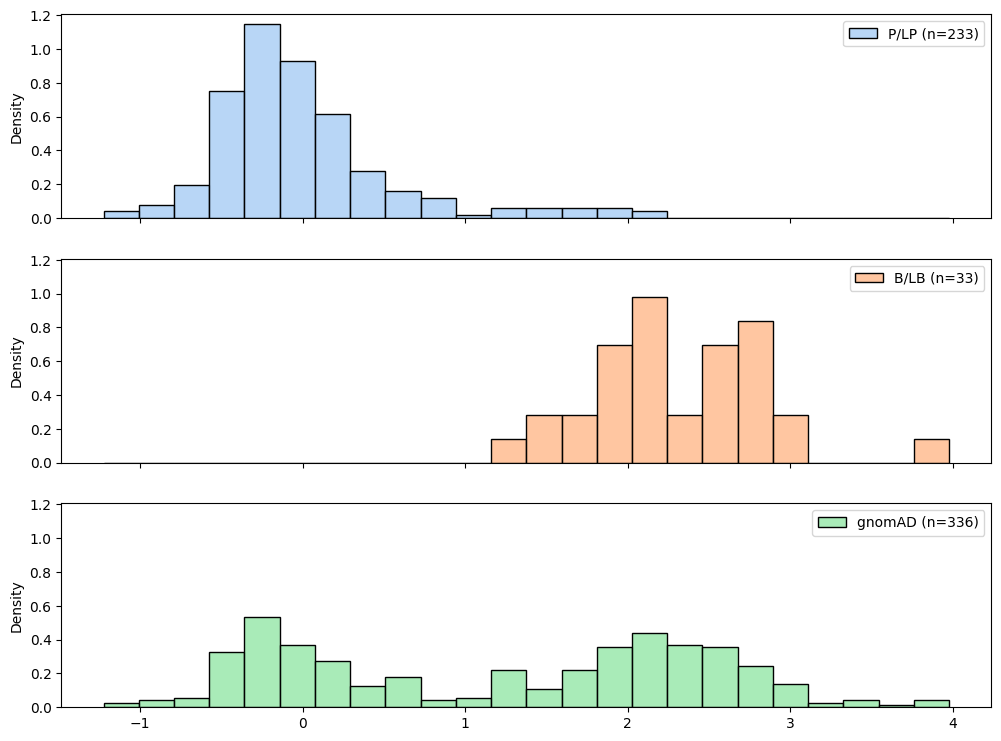

In [61]:
plotting.plot_samples({k : v.score.values for k,v in sample_data.items()})

In [62]:
pd.DataFrame.from_records([*[dict(sample_name='P/LP',score=score) for score in sample_data['P/LP'].score.values],
                            *[dict(sample_name='B/LB',score=score) for score in sample_data['B/LB'].score.values],
                            *[dict(sample_name='gnomAD',score=score) for score in sample_data['gnomAD'].score.values]]).to_csv(dataset_path / "samples.csv",index=False)

In [64]:
old = joblib.load(dataset_path / "hgvs_pro.pkl")

In [65]:
clinvar_hgvs_pro_summaries[clinvar_hgvs_pro_summaries.index.isin(set(old['p_lp'].values) - set(sample_data['P/LP'].hgvs_pro.values))]

,num_p_lp,num_b_lb,num_conflicting,num_VUS,clinvar_names,clinvar_records,clinvar_spliceAI_max
hgvs_pro,,,,,,,
p.Arg249Ser,1,0,1,0,NM_000546.6(TP53):c.747G>T (p.Arg249Ser)|NM_00...,2,0.00
p.Arg280Ser,1,0,1,0,NM_000546.6(TP53):c.840A>C (p.Arg280Ser)|NM_00...,2,0.01
p.Asp281Glu,1,0,0,1,NM_000546.6(TP53):c.843C>G (p.Asp281Glu)|NM_00...,2,0.01
p.Cys238Ser,1,0,1,0,NM_000546.6(TP53):c.713G>C (p.Cys238Ser)|NM_00...,2,0.11
p.Gly105Val,1,0,0,0,NM_000546.6(TP53):c.314G>T (p.Gly105Val),1,0.98
p.Met246Ile,2,0,0,1,NM_000546.6(TP53):c.738G>A (p.Met246Ile)|NM_00...,3,0.01
p.Phe109Ile,1,0,0,0,NM_000546.6(TP53):c.325T>A (p.Phe109Ile),1,0.64
p.Phe113Leu,1,0,0,1,NM_000546.6(TP53):c.339C>A (p.Phe113Leu)|NM_00...,2,0.04
p.Ser106Arg,1,0,0,0,NM_000546.6(TP53):c.318C>G (p.Ser106Arg),1,1.00
